In [57]:
import sys
import importlib

sys.path.insert(0, '/Users/awgol/code/syne-tune/')

import syne_tune
importlib.reload(syne_tune)

import syne_tune.experiments
importlib.reload(syne_tune.experiments)

from syne_tune.util import experiment_path, s3_experiment_path
importlib.reload(syne_tune.util)

import adam_scripts.utils
importlib.reload(adam_scripts.utils)

import adam_scripts.mo_metrics
import pygmo

import numpy as np
import pandas as pd
import tqdm
import boto3

from syne_tune.backend.sagemaker_backend.instance_info import InstanceInfos
instance_info = InstanceInfos()

import matplotlib.pyplot as plt

import seaborn as sns

from syne_tune.optimizer.schedulers.transfer_learning.quantile_based.normalization_transforms import (
    GaussianTransform)

In [2]:
boto3_client_sagemaker = boto3.client('sagemaker')
boto3_resource_cloudwatch = boto3.resource('cloudwatch')

In [3]:
df = syne_tune.experiments.load_experiment(
    'speed-bs-it-nw-new-2022-02-21-18-05-01-921', 
    force_download=False
).results

In [4]:
# Drop duplicates
temp = df.groupby(['trial_id', 'step']).loss.count().reset_index()
trial_ids_to_be_deleted = temp[temp.loss>1].trial_id.unique() 
trial_ids_to_be_deleted

array([2])

In [5]:
df.drop(df.index[df['trial_id'].isin(trial_ids_to_be_deleted)], inplace=True)

In [6]:
# Compute time per samples
dfg = df.groupby(['trial_id'])

number_of_samples_processed = \
  (dfg.step.max() - dfg.step.min()) * \
  dfg.config_per_device_train_batch_size.max() * \
  dfg.config_st_instance_type.max().map(lambda x: instance_info(x).num_gpu)

samples_processed_per_second = number_of_samples_processed / (dfg.st_worker_time.max()-dfg.st_worker_time.min())
time_per_sample = (dfg.st_worker_time.max() - dfg.st_worker_time.min()) / number_of_samples_processed
cost_per_sample = time_per_sample * dfg.config_st_instance_type.max().map(lambda x: instance_info(x).cost_per_hour)

In [7]:
b = pd.concat([
    samples_processed_per_second, 
    time_per_sample,
    cost_per_sample,
    dfg.config_seed.max(),
    dfg.st_worker_cost.max(), 
    dfg.config_st_instance_type.max(), 
    dfg.config_per_device_train_batch_size.max(),
    dfg.config_dataloader_num_workers.max(),
], axis=1)
columns = ['samples_processed_per_second', 'time_per_sample', 'cost_per_sample']
b.columns = columns + list(b.columns)[len(columns):]

b = b[b.config_seed == 1]

In [8]:
len(b)

154

In [9]:
b = b.dropna()
len(b)

154

Add failed runs

In [10]:
startup_overhead_time = 6 * 60  # 6min in seconds

In [11]:
# per_device_train_batch_size_list = [4, 8, 16, 24, 32, 40, 48]
per_device_train_batch_size_list = [8, 16, 24, 32, 40, 48]
dataloader_num_workers_list = [0, 1]
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]

In [12]:
names = [
    "config_st_instance_type", 
    "config_per_device_train_batch_size", 
    "config_dataloader_num_workers"
]

mind = pd.MultiIndex.from_product(
    [instance_types, per_device_train_batch_size_list, dataloader_num_workers_list], 
    names=names)
c = b.set_index(names).reindex(mind)

In [13]:
len(c)

168

In [14]:
len(instance_types)

14

In [15]:
2*14*6

168

In [16]:
for idx in c.st_worker_cost.isna().loc[lambda x: x==True].index:
    c.loc[idx].samples_processed_per_second = 0.0
    c.loc[idx].time_per_sample = 1.
    c.loc[idx].cost_per_sample = 1.
    c.loc[idx].config_seed = 1
    c.loc[idx].st_worker_cost = (instance_info(idx[0]).cost_per_hour /
                                 60. / 60. * startup_overhead_time)

In [17]:
c['time_per_sample_orig'] = c['time_per_sample']
c['cost_per_sample_orig'] = c['cost_per_sample']

c['time_per_sample'] = c['time_per_sample'] / c['time_per_sample'].min()
c['cost_per_sample'] = c['cost_per_sample'] / c['cost_per_sample'].min()

In [18]:
c

samples_processed_per_second  \
config_st_instance_type config_per_device_train_batch_size config_dataloader_num_workers                                 
ml.p3.2xlarge           8                                  0                                                 52.758022   
                                                           1                                                 56.504295   
                        16                                 0                                                 60.558144   
                                                           1                                                 64.433402   
                        24                                 0                                                 62.254925   
...                                                                                                                ...   
ml.g5.24xlarge          32                                 1                                                223.611149   
                        40                                 0                                                206.900058   
                                                           1                                                236.965983   
                        48                                 0                                                214.850723   
                                                           1                                                245.722170   

                                                                                          time_per_sample  \
config_st_instance_type config_per_device_train_batch_size config_dataloader_num_workers                    
ml.p3.2xlarge           8                                  0                                     4.657532   
                                                           1                                     4.348734   
                        16                                 0                                     4.057624   
                                                           1                                     3.813584   
                        24                                 0                                     3.947032   
...                                                                                                   ...   
ml.g5.24xlarge          32                                 1                                     1.098882   
                        40                                 0                                     1.187637   
                                                           1                                     1.036951   
                        48                                 0                                     1.143688   
                                                           1                                     1.000000   

                                                                                          cost_per_sample  \
config_st_instance_type config_per_device_train_batch_size config_dataloader_num_workers                    
ml.p3.2xlarge           8                                  0                                     5.455447   
                                                           1                                     5.093747   
                        16                                 0                                     4.752765   
                                                           1                                     4.466916   
                        24                                 0                                     4.623226   
...                                                                                                   ...   
ml.g5.24xlarge          32                                 1                                     2.740512   
                        40                                 0                                     2.96186

In [19]:
b['time_per_sample_orig'] = b['time_per_sample']
b['cost_per_sample_orig'] = b['cost_per_sample']

b['time_per_sample'] = b['time_per_sample'] / b['time_per_sample'].min()
b['cost_per_sample'] = b['cost_per_sample'] / b['cost_per_sample'].min()

In [93]:
c = c.reset_index()

In [94]:
ref_point = (246., 246.)

In [95]:
temp = b
hv = pygmo.hypervolume(tuple(zip(temp.time_per_sample, temp.cost_per_sample))).compute(ref_point)
np.product(ref_point) - hv

492.6687399131624

In [96]:
# # the smaller the better
temp = c
hv = pygmo.hypervolume(tuple(zip(temp.time_per_sample, temp.cost_per_sample))).compute(ref_point)
true_hv = np.product(ref_point) - hv
true_hv

492.66873991315515

In [24]:
data = dict()
costs = dict()

## random

In [25]:
N = 100

In [26]:
temp = c
scenario_label = 'random'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


In [27]:
temp = b
scenario_label = 'random_b'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


## only cheapest instance per GPU-type-and-number

In [28]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        # 'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]

temp = c.query('config_st_instance_type in @instance_types')
scenario_label = 'cheapest_instances'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.54it/s]


In [29]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        # 'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]

temp = b.query('config_st_instance_type in @instance_types')
scenario_label = 'cheapest_instances_b'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.78it/s]


## deterministically determining largest possible batch_size

In [30]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        # 'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]

temp = b.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

# add the cost of running two runs for each instance_type
costs[scenario_label] += 2 * (
    sum(temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type] +
        instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        for instance_type in instance_types)
  )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.14it/s]


## deterministically determining largest possible batch_size using only 1 instance_type

In [31]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += 2 * temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.65it/s]


In [32]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        # 'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type_cheapest_instances'

K = len(temp)


hvs_total = []
costs_total = []
for n in tqdm.trange(N):
    idxs = np.random.choice(K, size=K, replace=False)
    hvs_temp = []
    costs_temp = []
    for k in range(1, K + 1):
        temp2 = temp.iloc[idxs[:k]]
        hv = pygmo.hypervolume(tuple(zip(temp2.time_per_sample, temp2.cost_per_sample))).compute(ref_point)
        hvs_temp.append(np.product(ref_point) - hv)
        costs_temp.append(
            temp.st_worker_cost.iloc[idxs[k-1]] + 
            instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour/60./60.*startup_overhead_time
        )
    hvs_total.append(hvs_temp)
    costs_total.append(costs_temp)
    
data[scenario_label] = np.array(hvs_total) - true_hv
costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += 2 * temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.90it/s]


## BOTorch

In [33]:
# sp.finrange(8.0, 48.0, 6)
# mobo_runs = [
#     'simulated-tabular-backend-2022-03-31-14-17-09-497',
#     'simulated-tabular-backend-2022-03-31-14-32-40-324',
#     'simulated-tabular-backend-2022-03-31-14-40-16-865', 
#     'simulated-tabular-backend-2022-03-31-14-47-59-648', 
#     'simulated-tabular-backend-2022-04-01-08-20-59-011',
#     'simulated-tabular-backend-2022-04-01-12-15-52-804', 
#     'simulated-tabular-backend-2022-04-01-12-54-06-273', 
#     'simulated-tabular-backend-2022-04-01-13-05-57-111',
# ]

# now include the startup overhead
mobo_runs = [
    'simulated-tabular-backend-2022-04-01-13-42-13-074',
    'simulated-tabular-backend-2022-04-01-13-49-15-170', 
    'simulated-tabular-backend-2022-04-01-13-49-47-413', 
    'simulated-tabular-backend-2022-04-01-13-53-01-185',
    'simulated-tabular-backend-2022-04-01-14-32-12-859', 
    'simulated-tabular-backend-2022-04-01-14-33-43-503', 
    'simulated-tabular-backend-2022-04-01-14-35-33-367',
    'simulated-tabular-backend-2022-04-01-14-40-50-235', 
    'simulated-tabular-backend-2022-04-01-14-41-00-962', 
    'simulated-tabular-backend-2022-04-01-14-45-17-251',
]

mobo_runs = [
    'simulated-tabular-backend-2022-04-01-20-34-56-235', 'simulated-tabular-backend-2022-04-01-20-35-18-753', 'simulated-tabular-backend-2022-04-01-20-35-29-353', 'simulated-tabular-backend-2022-04-01-20-35-38-960', 'simulated-tabular-backend-2022-04-01-20-35-51-893', 'simulated-tabular-backend-2022-04-01-20-36-04-712', 'simulated-tabular-backend-2022-04-01-20-36-13-319', 'simulated-tabular-backend-2022-04-01-20-36-28-864', 'simulated-tabular-backend-2022-04-01-20-36-42-568', 'simulated-tabular-backend-2022-04-01-20-36-58-243']

mobo_runs = [
    'simulated-tabular-backend-2022-04-01-21-21-15-023', 'simulated-tabular-backend-2022-04-01-21-22-40-272', 'simulated-tabular-backend-2022-04-01-21-23-48-862', 'simulated-tabular-backend-2022-04-01-21-24-31-624', 'simulated-tabular-backend-2022-04-01-21-25-04-884', 'simulated-tabular-backend-2022-04-01-21-26-36-533', 'simulated-tabular-backend-2022-04-01-21-28-12-801', 'simulated-tabular-backend-2022-04-01-21-29-02-006', 'simulated-tabular-backend-2022-04-01-21-30-04-582', 'simulated-tabular-backend-2022-04-01-21-30-56-724', 'simulated-tabular-backend-2022-04-01-21-31-35-943', 'simulated-tabular-backend-2022-04-01-21-32-30-501', 'simulated-tabular-backend-2022-04-01-21-33-39-972', 'simulated-tabular-backend-2022-04-01-21-34-31-698', 'simulated-tabular-backend-2022-04-01-21-35-37-011', 'simulated-tabular-backend-2022-04-01-21-37-12-354', 'simulated-tabular-backend-2022-04-01-21-38-19-620', 'simulated-tabular-backend-2022-04-01-21-39-12-423', 'simulated-tabular-backend-2022-04-01-21-40-02-668', 'simulated-tabular-backend-2022-04-01-21-40-45-486', 'simulated-tabular-backend-2022-04-01-21-41-28-396', 'simulated-tabular-backend-2022-04-01-21-42-13-365', 'simulated-tabular-backend-2022-04-01-21-43-09-080', 'simulated-tabular-backend-2022-04-01-21-43-52-250', 'simulated-tabular-backend-2022-04-01-21-44-45-595', 'simulated-tabular-backend-2022-04-01-21-45-32-036', 'simulated-tabular-backend-2022-04-01-21-46-08-037', 'simulated-tabular-backend-2022-04-01-21-46-49-247', 'simulated-tabular-backend-2022-04-01-21-47-39-365', 'simulated-tabular-backend-2022-04-01-21-49-29-481', 'simulated-tabular-backend-2022-04-01-21-50-03-172', 'simulated-tabular-backend-2022-04-01-21-51-05-563', 'simulated-tabular-backend-2022-04-01-21-51-47-372', 'simulated-tabular-backend-2022-04-01-21-52-49-035', 'simulated-tabular-backend-2022-04-01-21-53-40-563', 'simulated-tabular-backend-2022-04-01-21-54-42-503', 'simulated-tabular-backend-2022-04-01-21-55-24-495', 'simulated-tabular-backend-2022-04-01-21-56-18-350', 'simulated-tabular-backend-2022-04-01-21-57-27-440', 'simulated-tabular-backend-2022-04-01-21-58-16-451', 'simulated-tabular-backend-2022-04-01-21-59-03-233', 'simulated-tabular-backend-2022-04-01-21-59-50-082', 'simulated-tabular-backend-2022-04-01-22-00-48-568', 'simulated-tabular-backend-2022-04-01-22-01-47-839', 'simulated-tabular-backend-2022-04-01-22-02-30-152', 'simulated-tabular-backend-2022-04-01-22-03-20-757', 'simulated-tabular-backend-2022-04-01-22-04-25-350', 'simulated-tabular-backend-2022-04-01-22-05-09-914', 'simulated-tabular-backend-2022-04-01-22-06-17-386', 'simulated-tabular-backend-2022-04-01-22-07-17-134', 'simulated-tabular-backend-2022-04-01-22-08-01-013', 'simulated-tabular-backend-2022-04-01-22-09-07-345', 'simulated-tabular-backend-2022-04-01-22-09-54-574', 'simulated-tabular-backend-2022-04-01-22-10-59-672', 'simulated-tabular-backend-2022-04-01-22-11-49-807', 'simulated-tabular-backend-2022-04-01-22-12-42-914', 'simulated-tabular-backend-2022-04-01-22-13-31-777', 'simulated-tabular-backend-2022-04-01-22-14-41-028', 'simulated-tabular-backend-2022-04-01-22-15-30-616', 'simulated-tabular-backend-2022-04-01-22-16-30-617', 'simulated-tabular-backend-2022-04-01-22-17-42-695', 'simulated-tabular-backend-2022-04-01-22-18-50-079', 'simulated-tabular-backend-2022-04-01-22-19-24-224', 'simulated-tabular-backend-2022-04-01-22-20-22-761', 'simulated-tabular-backend-2022-04-01-22-21-15-568', 'simulated-tabular-backend-2022-04-01-22-21-52-514', 'simulated-tabular-backend-2022-04-01-22-23-08-171', 'simulated-tabular-backend-2022-04-01-22-24-20-184', 'simulated-tabular-backend-2022-04-01-22-25-09-485', 'simulated-tabular-backend-2022-04-01-22-26-02-537', 'simulated-tabular-backend-2022-04-01-22-27-00-390', 'simulated-tabular-backend-2022-04-01-22-27-48-937', 'simulated-tabular-backend-2022-04-01-22-28-23-851', 'simulated-tabular-backend-2022-04-01-22-29-20-393', 'simulated-tabular-backend-2022-04-01-22-30-15-127', 'simulated-tabular-backend-2022-04-01-22-31-03-189', 'simulated-tabular-backend-2022-04-01-22-31-57-496', 'simulated-tabular-backend-2022-04-01-22-32-51-290', 'simulated-tabular-backend-2022-04-01-22-33-31-861', 'simulated-tabular-backend-2022-04-01-22-34-36-858', 'simulated-tabular-backend-2022-04-01-22-35-30-023', 'simulated-tabular-backend-2022-04-01-22-36-33-168', 'simulated-tabular-backend-2022-04-01-22-37-12-587', 'simulated-tabular-backend-2022-04-01-22-38-53-368', 'simulated-tabular-backend-2022-04-01-22-39-36-630', 'simulated-tabular-backend-2022-04-01-22-40-58-234', 'simulated-tabular-backend-2022-04-01-22-42-00-941', 'simulated-tabular-backend-2022-04-01-22-43-25-060', 'simulated-tabular-backend-2022-04-01-22-44-12-200', 'simulated-tabular-backend-2022-04-01-22-45-00-352', 'simulated-tabular-backend-2022-04-01-22-45-33-494', 'simulated-tabular-backend-2022-04-01-22-46-28-914', 'simulated-tabular-backend-2022-04-01-22-47-30-890', 'simulated-tabular-backend-2022-04-01-22-48-22-066', 'simulated-tabular-backend-2022-04-01-22-48-56-210', 'simulated-tabular-backend-2022-04-01-22-49-43-042', 'simulated-tabular-backend-2022-04-01-22-50-41-280', 'simulated-tabular-backend-2022-04-01-22-51-43-076', 'simulated-tabular-backend-2022-04-01-22-52-15-080', 'simulated-tabular-backend-2022-04-01-22-53-06-542']

# max_cost=90.
mobo_runs = [
    'simulated-tabular-backend-2022-04-02-11-32-07-059', 'simulated-tabular-backend-2022-04-02-11-34-13-742', 'simulated-tabular-backend-2022-04-02-11-36-29-449', 'simulated-tabular-backend-2022-04-02-11-38-48-917', 'simulated-tabular-backend-2022-04-02-11-42-28-178', 'simulated-tabular-backend-2022-04-02-11-46-50-285', 'simulated-tabular-backend-2022-04-02-11-48-55-529', 'simulated-tabular-backend-2022-04-02-11-52-38-602', 'simulated-tabular-backend-2022-04-02-11-55-14-776', 'simulated-tabular-backend-2022-04-02-11-57-51-326', 'simulated-tabular-backend-2022-04-02-11-59-38-413', 'simulated-tabular-backend-2022-04-02-12-01-59-051', 'simulated-tabular-backend-2022-04-02-12-03-52-917', 'simulated-tabular-backend-2022-04-02-12-06-09-051', 'simulated-tabular-backend-2022-04-02-12-08-26-640', 'simulated-tabular-backend-2022-04-02-12-10-51-805', 'simulated-tabular-backend-2022-04-02-12-13-54-590', 'simulated-tabular-backend-2022-04-02-12-17-16-249', 'simulated-tabular-backend-2022-04-02-12-20-46-701', 'simulated-tabular-backend-2022-04-02-12-23-19-136', 'simulated-tabular-backend-2022-04-02-12-26-47-500', 'simulated-tabular-backend-2022-04-02-12-29-05-755', 'simulated-tabular-backend-2022-04-02-12-31-17-183', 'simulated-tabular-backend-2022-04-02-12-33-28-130', 'simulated-tabular-backend-2022-04-02-12-35-28-179', 'simulated-tabular-backend-2022-04-02-12-37-35-703', 'simulated-tabular-backend-2022-04-02-12-39-38-918', 'simulated-tabular-backend-2022-04-02-12-41-39-909', 'simulated-tabular-backend-2022-04-02-12-43-34-890', 'simulated-tabular-backend-2022-04-02-12-46-07-585', 'simulated-tabular-backend-2022-04-02-12-48-12-612', 'simulated-tabular-backend-2022-04-02-12-52-55-255', 'simulated-tabular-backend-2022-04-02-12-55-52-424', 'simulated-tabular-backend-2022-04-02-12-57-54-069', 'simulated-tabular-backend-2022-04-02-13-01-24-388', 'simulated-tabular-backend-2022-04-02-13-03-41-973', 'simulated-tabular-backend-2022-04-02-13-06-09-719', 'simulated-tabular-backend-2022-04-02-13-09-03-571', 'simulated-tabular-backend-2022-04-02-13-12-22-092', 'simulated-tabular-backend-2022-04-02-13-14-34-363', 'simulated-tabular-backend-2022-04-02-13-16-57-804', 'simulated-tabular-backend-2022-04-02-13-19-07-814', 'simulated-tabular-backend-2022-04-02-13-21-33-550', 'simulated-tabular-backend-2022-04-02-13-23-48-639', 'simulated-tabular-backend-2022-04-02-13-25-30-075', 'simulated-tabular-backend-2022-04-02-13-28-36-861', 'simulated-tabular-backend-2022-04-02-13-31-23-664', 'simulated-tabular-backend-2022-04-02-13-33-31-617', 'simulated-tabular-backend-2022-04-02-13-36-51-346', 'simulated-tabular-backend-2022-04-02-13-39-33-114', 'simulated-tabular-backend-2022-04-02-13-42-23-942', 'simulated-tabular-backend-2022-04-02-13-49-08-525', 'simulated-tabular-backend-2022-04-02-13-51-05-732', 'simulated-tabular-backend-2022-04-02-13-54-51-509', 'simulated-tabular-backend-2022-04-02-13-58-06-121', 'simulated-tabular-backend-2022-04-02-14-01-35-891', 'simulated-tabular-backend-2022-04-02-14-03-14-845', 'simulated-tabular-backend-2022-04-02-14-05-22-434', 'simulated-tabular-backend-2022-04-02-14-08-17-973', 'simulated-tabular-backend-2022-04-02-14-10-11-361', 'simulated-tabular-backend-2022-04-02-14-12-40-709', 'simulated-tabular-backend-2022-04-02-14-14-51-011', 'simulated-tabular-backend-2022-04-02-14-17-15-108', 'simulated-tabular-backend-2022-04-02-14-20-08-177', 'simulated-tabular-backend-2022-04-02-14-22-09-072', 'simulated-tabular-backend-2022-04-02-14-24-20-883', 'simulated-tabular-backend-2022-04-02-14-26-47-219', 'simulated-tabular-backend-2022-04-02-14-29-29-634', 'simulated-tabular-backend-2022-04-02-14-31-44-251', 'simulated-tabular-backend-2022-04-02-14-33-49-351', 'simulated-tabular-backend-2022-04-02-14-36-25-088', 'simulated-tabular-backend-2022-04-02-14-39-21-786', 'simulated-tabular-backend-2022-04-02-14-41-19-660', 'simulated-tabular-backend-2022-04-02-14-43-31-307', 'simulated-tabular-backend-2022-04-02-14-45-38-703', 'simulated-tabular-backend-2022-04-02-14-47-53-177', 'simulated-tabular-backend-2022-04-02-14-49-59-355', 'simulated-tabular-backend-2022-04-02-14-52-50-810', 'simulated-tabular-backend-2022-04-02-14-55-51-030', 'simulated-tabular-backend-2022-04-02-14-57-38-421', 'simulated-tabular-backend-2022-04-02-14-59-33-422', 'simulated-tabular-backend-2022-04-02-15-02-23-642', 'simulated-tabular-backend-2022-04-02-15-05-20-503', 'simulated-tabular-backend-2022-04-02-15-07-50-404', 'simulated-tabular-backend-2022-04-02-15-09-51-981', 'simulated-tabular-backend-2022-04-02-15-13-37-862', 'simulated-tabular-backend-2022-04-02-15-16-32-852', 'simulated-tabular-backend-2022-04-02-15-18-43-383', 'simulated-tabular-backend-2022-04-02-15-20-45-191', 'simulated-tabular-backend-2022-04-02-15-23-38-660', 'simulated-tabular-backend-2022-04-02-15-26-12-029', 'simulated-tabular-backend-2022-04-02-15-28-35-649', 'simulated-tabular-backend-2022-04-02-15-31-13-301', 'simulated-tabular-backend-2022-04-02-15-33-33-099', 'simulated-tabular-backend-2022-04-02-15-35-30-366', 'simulated-tabular-backend-2022-04-02-15-38-51-603', 'simulated-tabular-backend-2022-04-02-15-40-33-356', 'simulated-tabular-backend-2022-04-02-15-42-32-287', 'simulated-tabular-backend-2022-04-02-15-45-00-507', 'simulated-tabular-backend-2022-04-02-15-48-18-577']

In [34]:
scenario_label = 'mobo'
runs = mobo_runs

temp_data = []
temp_cost = []
for run in runs:
    dfff = syne_tune.experiments.load_experiment(run).results

    dfff['training-runtime-per-sample-rel'] = dfff['training-runtime-per-sample'] / c['time_per_sample_orig'].min()
    dfff['training-cost-per-sample-rel'] = dfff['training-cost-per-sample'] / c['cost_per_sample_orig'].min()

    temp_data.append([
        np.product(ref_point) - true_hv - 
        pygmo.hypervolume(tuple(zip(dfff['training-runtime-per-sample-rel'][:i+1], 
                                    dfff['training-cost-per-sample-rel'][:i+1]))).compute(ref_point) 
        for i in range(len(dfff))])

    temp_cost.append(np.cumsum(dfff.st_worker_cost))

min_index = min(len(v) for v in temp_data)
data[scenario_label] = np.zeros((len(temp_data), min_index))
costs[scenario_label] = np.zeros((len(temp_data), min_index))
for i in range(len(temp_data)):
    data[scenario_label][i, :] = temp_data[i][:min_index]
    costs[scenario_label][i, :] = temp_cost[i][:min_index]
    
print(data[scenario_label].shape)

(100, 122)


## Syne Tune RandomSearch

In [35]:
rs_runs = [
    'simulated-tabular-backend-2022-04-01-13-42-35-763', 'simulated-tabular-backend-2022-04-01-13-42-37-815', 'simulated-tabular-backend-2022-04-01-13-42-39-863', 'simulated-tabular-backend-2022-04-01-13-42-41-938', 'simulated-tabular-backend-2022-04-01-13-42-43-953', 'simulated-tabular-backend-2022-04-01-13-42-45-992', 'simulated-tabular-backend-2022-04-01-13-42-48-070', 'simulated-tabular-backend-2022-04-01-13-42-50-316', 'simulated-tabular-backend-2022-04-01-13-42-52-537', 'simulated-tabular-backend-2022-04-01-13-42-55-437', 'simulated-tabular-backend-2022-04-01-13-42-58-179', 'simulated-tabular-backend-2022-04-01-13-43-01-191', 'simulated-tabular-backend-2022-04-01-13-43-03-678', 'simulated-tabular-backend-2022-04-01-13-43-05-897', 'simulated-tabular-backend-2022-04-01-13-43-08-069', 'simulated-tabular-backend-2022-04-01-13-43-10-372', 'simulated-tabular-backend-2022-04-01-13-43-12-560', 'simulated-tabular-backend-2022-04-01-13-43-15-010', 'simulated-tabular-backend-2022-04-01-13-43-17-770', 'simulated-tabular-backend-2022-04-01-13-43-20-113', 'simulated-tabular-backend-2022-04-01-13-43-22-246', 'simulated-tabular-backend-2022-04-01-13-43-24-663', 'simulated-tabular-backend-2022-04-01-13-43-26-981', 'simulated-tabular-backend-2022-04-01-13-43-29-563', 'simulated-tabular-backend-2022-04-01-13-43-31-787', 'simulated-tabular-backend-2022-04-01-13-43-34-793', 'simulated-tabular-backend-2022-04-01-13-43-37-010', 'simulated-tabular-backend-2022-04-01-13-43-39-169', 'simulated-tabular-backend-2022-04-01-13-43-41-701', 'simulated-tabular-backend-2022-04-01-13-43-43-842', 'simulated-tabular-backend-2022-04-01-13-43-46-041', 'simulated-tabular-backend-2022-04-01-13-43-48-163', 'simulated-tabular-backend-2022-04-01-13-43-50-307', 'simulated-tabular-backend-2022-04-01-13-43-52-436', 'simulated-tabular-backend-2022-04-01-13-43-54-685', 'simulated-tabular-backend-2022-04-01-13-43-56-829', 'simulated-tabular-backend-2022-04-01-13-43-59-276', 'simulated-tabular-backend-2022-04-01-13-44-02-065', 'simulated-tabular-backend-2022-04-01-13-44-04-437', 'simulated-tabular-backend-2022-04-01-13-44-06-527', 'simulated-tabular-backend-2022-04-01-13-44-08-667', 'simulated-tabular-backend-2022-04-01-13-44-11-330', 'simulated-tabular-backend-2022-04-01-13-44-13-588', 'simulated-tabular-backend-2022-04-01-13-44-15-738', 'simulated-tabular-backend-2022-04-01-13-44-18-026', 'simulated-tabular-backend-2022-04-01-13-44-20-390', 'simulated-tabular-backend-2022-04-01-13-44-22-647', 'simulated-tabular-backend-2022-04-01-13-44-24-886', 'simulated-tabular-backend-2022-04-01-13-44-26-983', 'simulated-tabular-backend-2022-04-01-13-44-29-292', 'simulated-tabular-backend-2022-04-01-13-44-31-572', 'simulated-tabular-backend-2022-04-01-13-44-33-879', 'simulated-tabular-backend-2022-04-01-13-44-36-124', 'simulated-tabular-backend-2022-04-01-13-44-38-556', 'simulated-tabular-backend-2022-04-01-13-44-41-320', 'simulated-tabular-backend-2022-04-01-13-44-43-844', 'simulated-tabular-backend-2022-04-01-13-44-46-413', 'simulated-tabular-backend-2022-04-01-13-44-48-760', 'simulated-tabular-backend-2022-04-01-13-44-51-144', 'simulated-tabular-backend-2022-04-01-13-44-53-455', 'simulated-tabular-backend-2022-04-01-13-44-55-996', 'simulated-tabular-backend-2022-04-01-13-44-58-412', 'simulated-tabular-backend-2022-04-01-13-45-00-731', 'simulated-tabular-backend-2022-04-01-13-45-03-031', 'simulated-tabular-backend-2022-04-01-13-45-05-363', 'simulated-tabular-backend-2022-04-01-13-45-07-762', 'simulated-tabular-backend-2022-04-01-13-45-10-286', 'simulated-tabular-backend-2022-04-01-13-45-12-605', 'simulated-tabular-backend-2022-04-01-13-45-15-018', 'simulated-tabular-backend-2022-04-01-13-45-17-383', 'simulated-tabular-backend-2022-04-01-13-45-19-874', 'simulated-tabular-backend-2022-04-01-13-45-22-214', 'simulated-tabular-backend-2022-04-01-13-45-24-470', 'simulated-tabular-backend-2022-04-01-13-45-26-971', 'simulated-tabular-backend-2022-04-01-13-45-29-683', 'simulated-tabular-backend-2022-04-01-13-45-31-973', 'simulated-tabular-backend-2022-04-01-13-45-34-147', 'simulated-tabular-backend-2022-04-01-13-45-36-261', 'simulated-tabular-backend-2022-04-01-13-45-38-432', 'simulated-tabular-backend-2022-04-01-13-45-40-722', 'simulated-tabular-backend-2022-04-01-13-45-42-978', 'simulated-tabular-backend-2022-04-01-13-45-45-239', 'simulated-tabular-backend-2022-04-01-13-45-47-196', 'simulated-tabular-backend-2022-04-01-13-45-49-074', 'simulated-tabular-backend-2022-04-01-13-45-50-984', 'simulated-tabular-backend-2022-04-01-13-45-52-888', 'simulated-tabular-backend-2022-04-01-13-45-54-804', 'simulated-tabular-backend-2022-04-01-13-45-56-763', 'simulated-tabular-backend-2022-04-01-13-45-58-668', 'simulated-tabular-backend-2022-04-01-13-46-00-548', 'simulated-tabular-backend-2022-04-01-13-46-02-403', 'simulated-tabular-backend-2022-04-01-13-46-04-348', 'simulated-tabular-backend-2022-04-01-13-46-06-522', 'simulated-tabular-backend-2022-04-01-13-46-08-744', 'simulated-tabular-backend-2022-04-01-13-46-10-874', 'simulated-tabular-backend-2022-04-01-13-46-12-778', 'simulated-tabular-backend-2022-04-01-13-46-14-704', 'simulated-tabular-backend-2022-04-01-13-46-16-578', 'simulated-tabular-backend-2022-04-01-13-46-18-385', 'simulated-tabular-backend-2022-04-01-13-46-20-242']

In [36]:
scenario_label = 'rs_st'
runs = rs_runs

temp_data = []
temp_cost = []
for run in runs:
    dfff = syne_tune.experiments.load_experiment(run).results

    dfff['training-runtime-per-sample-rel'] = dfff['training-runtime-per-sample'] / c['time_per_sample_orig'].min()
    dfff['training-cost-per-sample-rel'] = dfff['training-cost-per-sample'] / c['cost_per_sample_orig'].min()

    temp_data.append([
        np.product(ref_point) - true_hv - 
        pygmo.hypervolume(tuple(zip(dfff['training-runtime-per-sample-rel'][:i+1], 
                                    dfff['training-cost-per-sample-rel'][:i+1]))).compute(ref_point) 
        for i in range(len(dfff))])

    temp_cost.append(np.cumsum(dfff.st_worker_cost))

min_index = min(len(v) for v in temp_data)
data[scenario_label] = np.zeros((len(temp_data), min_index))
costs[scenario_label] = np.zeros((len(temp_data), min_index))
for i in range(len(temp_data)):
    data[scenario_label][i, :] = temp_data[i][:min_index]
    costs[scenario_label][i, :] = temp_cost[i][:min_index]
    
print(data[scenario_label].shape)

(100, 158)


## Rich-feature MOBO

In [37]:
rf_mobo_runs = [
    'simulated-tabular-backend-2022-04-07-14-22-51-061', 'simulated-tabular-backend-2022-04-07-14-23-52-407', 'simulated-tabular-backend-2022-04-07-14-24-20-376', 'simulated-tabular-backend-2022-04-07-14-24-48-987', 'simulated-tabular-backend-2022-04-07-14-25-15-335', 'simulated-tabular-backend-2022-04-07-14-25-38-987', 'simulated-tabular-backend-2022-04-07-14-26-14-501', 'simulated-tabular-backend-2022-04-07-14-26-30-440', 'simulated-tabular-backend-2022-04-07-14-27-03-554', 'simulated-tabular-backend-2022-04-07-14-27-27-091']

rf_mobo_runs = [
    'simulated-tabular-backend-2022-04-07-14-40-59-865', 'simulated-tabular-backend-2022-04-07-14-42-07-202', 'simulated-tabular-backend-2022-04-07-14-43-25-586', 'simulated-tabular-backend-2022-04-07-14-44-34-443', 'simulated-tabular-backend-2022-04-07-14-45-42-625', 'simulated-tabular-backend-2022-04-07-14-47-27-087', 'simulated-tabular-backend-2022-04-07-14-48-25-994', 'simulated-tabular-backend-2022-04-07-14-49-51-141', 'simulated-tabular-backend-2022-04-07-14-51-17-875', 'simulated-tabular-backend-2022-04-07-14-52-25-313']

# max_cost=70., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu', 'num_cpu', 'cost_per_hour']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-07-14-55-54-573', 'simulated-tabular-backend-2022-04-07-15-09-00-151']

# max_cost=70., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu', 'cost_per_hour']
rf_mobo_runs = [
    'simulated-tabular-backend-2022-04-07-15-20-15-689', 'simulated-tabular-backend-2022-04-07-15-22-17-915', 'simulated-tabular-backend-2022-04-07-15-24-10-379', 'simulated-tabular-backend-2022-04-07-15-26-05-736', 'simulated-tabular-backend-2022-04-07-15-28-07-394', 'simulated-tabular-backend-2022-04-07-15-30-04-821', 'simulated-tabular-backend-2022-04-07-15-31-53-983', 'simulated-tabular-backend-2022-04-07-15-33-48-174', 'simulated-tabular-backend-2022-04-07-15-35-31-210', 'simulated-tabular-backend-2022-04-07-15-37-17-189']

# max_cost=20., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu']

# max_cost=20., self.instance_type_features = ['config_st_instance_type', 'num_gpu']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-14-30-00-850', 'simulated-tabular-backend-2022-04-08-14-30-27-821', 'simulated-tabular-backend-2022-04-08-14-30-48-042', 'simulated-tabular-backend-2022-04-08-14-31-30-577', 'simulated-tabular-backend-2022-04-08-14-32-06-036', 'simulated-tabular-backend-2022-04-08-14-32-33-762', 'simulated-tabular-backend-2022-04-08-14-32-48-042', 'simulated-tabular-backend-2022-04-08-14-33-08-101', 'simulated-tabular-backend-2022-04-08-14-33-20-845', 'simulated-tabular-backend-2022-04-08-14-33-44-442']

# BASELINE
# max_cost=20., self.instance_type_features = ['config_st_instance_type']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-14-40-52-917', 'simulated-tabular-backend-2022-04-08-14-41-10-941', 'simulated-tabular-backend-2022-04-08-14-41-50-172', 'simulated-tabular-backend-2022-04-08-14-42-06-368', 'simulated-tabular-backend-2022-04-08-14-42-30-473', 'simulated-tabular-backend-2022-04-08-14-42-53-084', 'simulated-tabular-backend-2022-04-08-14-43-12-323', 'simulated-tabular-backend-2022-04-08-14-43-34-447', 'simulated-tabular-backend-2022-04-08-14-43-52-548', 'simulated-tabular-backend-2022-04-08-14-44-16-604']

# BASELINE AFTER GIT STASH
rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-15-25-00-304', 'simulated-tabular-backend-2022-04-08-15-25-21-356', 'simulated-tabular-backend-2022-04-08-15-25-55-514', 'simulated-tabular-backend-2022-04-08-15-26-12-394', 'simulated-tabular-backend-2022-04-08-15-26-29-980', 'simulated-tabular-backend-2022-04-08-15-26-53-001', 'simulated-tabular-backend-2022-04-08-15-27-05-618', 'simulated-tabular-backend-2022-04-08-15-27-25-286', 'simulated-tabular-backend-2022-04-08-15-27-43-510', 'simulated-tabular-backend-2022-04-08-15-28-26-086']

# Unstashed, fixed a categorical embedding bug - now reproduces the results
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-08-52-44-256', 'simulated-tabular-backend-2022-04-11-08-53-30-477', 'simulated-tabular-backend-2022-04-11-08-54-29-240', 'simulated-tabular-backend-2022-04-11-08-54-52-139', 'simulated-tabular-backend-2022-04-11-08-55-21-475', 'simulated-tabular-backend-2022-04-11-08-55-42-895', 'simulated-tabular-backend-2022-04-11-08-56-15-720', 'simulated-tabular-backend-2022-04-11-08-56-45-222', 'simulated-tabular-backend-2022-04-11-08-57-23-555', 'simulated-tabular-backend-2022-04-11-08-57-52-127']

# max_cost=20., self.instance_type_features = ['GPUFP32TFLOPS'] - still worse than random search
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-06-59-209', 'simulated-tabular-backend-2022-04-11-09-07-43-183', 'simulated-tabular-backend-2022-04-11-09-08-17-710', 'simulated-tabular-backend-2022-04-11-09-08-50-725']

# max_cost=90., self.instance_type_features = ['GPUFP32TFLOPS'] - to test if it will go to zero
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-14-57-548', 'simulated-tabular-backend-2022-04-11-09-19-47-646']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-50-31-343',]

# max_cost=25., self.instance_type_features = ['cost_per_hour']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-10-05-13-309', 'simulated-tabular-backend-2022-04-11-10-05-43-640']

# BASELINE after refactoring
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-15-45-15-474', 'simulated-tabular-backend-2022-04-11-15-46-18-789', 'simulated-tabular-backend-2022-04-11-15-47-01-860', 'simulated-tabular-backend-2022-04-11-15-47-50-496', 'simulated-tabular-backend-2022-04-11-15-48-33-679', 'simulated-tabular-backend-2022-04-11-15-49-24-111', 'simulated-tabular-backend-2022-04-11-15-50-13-528', 'simulated-tabular-backend-2022-04-11-15-50-51-074', 'simulated-tabular-backend-2022-04-11-15-51-32-226', 'simulated-tabular-backend-2022-04-11-15-52-17-277']

# after refactoring, max_cost=25., self.instance_type_features = ['cost_per_hour']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-15-55-27-006', 'simulated-tabular-backend-2022-04-11-15-55-52-330', 'simulated-tabular-backend-2022-04-11-15-56-13-444', 'simulated-tabular-backend-2022-04-11-15-56-44-575', 'simulated-tabular-backend-2022-04-11-15-57-10-029', 'simulated-tabular-backend-2022-04-11-15-57-52-324', 'simulated-tabular-backend-2022-04-11-15-58-30-617', 'simulated-tabular-backend-2022-04-11-15-58-51-525', 'simulated-tabular-backend-2022-04-11-15-59-14-640', 'simulated-tabular-backend-2022-04-11-15-59-46-539']

# after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS']
# actually improves things
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-16-40-34-902', 'simulated-tabular-backend-2022-04-11-16-41-32-274', 'simulated-tabular-backend-2022-04-11-16-42-22-119', 'simulated-tabular-backend-2022-04-11-16-43-23-825', 'simulated-tabular-backend-2022-04-11-16-44-17-644', 'simulated-tabular-backend-2022-04-11-16-44-52-512', 'simulated-tabular-backend-2022-04-11-16-46-08-876', 'simulated-tabular-backend-2022-04-11-16-47-16-703', 'simulated-tabular-backend-2022-04-11-16-48-08-034', 'simulated-tabular-backend-2022-04-11-16-49-17-501']

# after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS*num_gpu']
# not as good as the previous one
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-00-47-694', 'simulated-tabular-backend-2022-04-11-17-01-33-573', 'simulated-tabular-backend-2022-04-11-17-02-08-197', 'simulated-tabular-backend-2022-04-11-17-02-40-412', 'simulated-tabular-backend-2022-04-11-17-03-07-167', 'simulated-tabular-backend-2022-04-11-17-03-33-492', 'simulated-tabular-backend-2022-04-11-17-04-06-442', 'simulated-tabular-backend-2022-04-11-17-04-27-605', 'simulated-tabular-backend-2022-04-11-17-04-47-220', 'simulated-tabular-backend-2022-04-11-17-05-25-529']

# after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS*num_gpu', 'cost_per_hour']
# exactly the same as just categorical
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-06-28-297', 'simulated-tabular-backend-2022-04-11-17-07-32-765', 'simulated-tabular-backend-2022-04-11-17-08-06-675', 'simulated-tabular-backend-2022-04-11-17-08-41-604', 'simulated-tabular-backend-2022-04-11-17-09-08-951', 'simulated-tabular-backend-2022-04-11-17-09-44-527', 'simulated-tabular-backend-2022-04-11-17-10-10-429', 'simulated-tabular-backend-2022-04-11-17-10-51-152', 'simulated-tabular-backend-2022-04-11-17-11-13-969', 'simulated-tabular-backend-2022-04-11-17-11-34-681']

# 100 trials, max_cost=50., self.instance_type_features = ['GPUFP32TFLOPS']
rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-33-57-906', 'simulated-tabular-backend-2022-04-11-17-35-39-266', 'simulated-tabular-backend-2022-04-11-17-37-03-418', 'simulated-tabular-backend-2022-04-11-17-39-01-702', 'simulated-tabular-backend-2022-04-11-17-40-54-671', 'simulated-tabular-backend-2022-04-11-17-42-10-608', 'simulated-tabular-backend-2022-04-11-17-43-58-965', 'simulated-tabular-backend-2022-04-11-17-45-05-450', 'simulated-tabular-backend-2022-04-11-17-46-41-040', 'simulated-tabular-backend-2022-04-11-17-48-15-112', 'simulated-tabular-backend-2022-04-11-17-49-57-006', 'simulated-tabular-backend-2022-04-11-17-51-35-892', 'simulated-tabular-backend-2022-04-11-17-52-46-929', 'simulated-tabular-backend-2022-04-11-17-54-47-168', 'simulated-tabular-backend-2022-04-11-17-56-16-904', 'simulated-tabular-backend-2022-04-11-17-57-57-765', 'simulated-tabular-backend-2022-04-11-17-59-23-204', 'simulated-tabular-backend-2022-04-11-18-00-50-710', 'simulated-tabular-backend-2022-04-11-18-02-46-260', 'simulated-tabular-backend-2022-04-11-18-04-41-583', 'simulated-tabular-backend-2022-04-11-18-06-28-985', 'simulated-tabular-backend-2022-04-11-18-08-03-454', 'simulated-tabular-backend-2022-04-11-18-09-35-378', 'simulated-tabular-backend-2022-04-11-18-11-16-763', 'simulated-tabular-backend-2022-04-11-18-12-21-343', 'simulated-tabular-backend-2022-04-11-18-13-53-339', 'simulated-tabular-backend-2022-04-11-18-15-51-660', 'simulated-tabular-backend-2022-04-11-18-17-35-176', 'simulated-tabular-backend-2022-04-11-18-18-07-628', 'simulated-tabular-backend-2022-04-11-18-18-43-389', 'simulated-tabular-backend-2022-04-11-18-20-04-498', 'simulated-tabular-backend-2022-04-11-18-21-31-250', 'simulated-tabular-backend-2022-04-11-18-23-23-709', 'simulated-tabular-backend-2022-04-11-18-25-05-484', 'simulated-tabular-backend-2022-04-11-18-26-21-496', 'simulated-tabular-backend-2022-04-11-18-27-37-656', 'simulated-tabular-backend-2022-04-11-18-29-24-956', 'simulated-tabular-backend-2022-04-11-18-30-34-085', 'simulated-tabular-backend-2022-04-11-18-31-53-863', 'simulated-tabular-backend-2022-04-11-18-33-47-773', 'simulated-tabular-backend-2022-04-11-18-35-44-236', 'simulated-tabular-backend-2022-04-11-18-37-32-086', 'simulated-tabular-backend-2022-04-11-18-38-55-076', 'simulated-tabular-backend-2022-04-11-18-40-31-505', 'simulated-tabular-backend-2022-04-11-18-41-42-651', 'simulated-tabular-backend-2022-04-11-18-43-19-490', 'simulated-tabular-backend-2022-04-11-18-44-57-417', 'simulated-tabular-backend-2022-04-11-18-46-21-576', 'simulated-tabular-backend-2022-04-11-18-47-43-988', 'simulated-tabular-backend-2022-04-11-18-48-57-980', 'simulated-tabular-backend-2022-04-11-18-50-29-809', 'simulated-tabular-backend-2022-04-11-18-51-58-300', 'simulated-tabular-backend-2022-04-11-18-53-58-035', 'simulated-tabular-backend-2022-04-11-18-55-36-612', 'simulated-tabular-backend-2022-04-11-18-57-26-668', 'simulated-tabular-backend-2022-04-11-18-59-11-429', 'simulated-tabular-backend-2022-04-11-19-00-18-522', 'simulated-tabular-backend-2022-04-11-19-01-32-909', 'simulated-tabular-backend-2022-04-11-19-03-26-602', 'simulated-tabular-backend-2022-04-11-19-04-47-663', 'simulated-tabular-backend-2022-04-11-19-06-17-059', 'simulated-tabular-backend-2022-04-11-19-07-50-591', 'simulated-tabular-backend-2022-04-11-19-09-07-892', 'simulated-tabular-backend-2022-04-11-19-11-04-693', 'simulated-tabular-backend-2022-04-11-19-12-33-264', 'simulated-tabular-backend-2022-04-11-19-14-07-235', 'simulated-tabular-backend-2022-04-11-19-15-34-633', 'simulated-tabular-backend-2022-04-11-19-16-50-708', 'simulated-tabular-backend-2022-04-11-19-18-36-691', 'simulated-tabular-backend-2022-04-11-19-19-56-870', 'simulated-tabular-backend-2022-04-11-19-21-21-058', 'simulated-tabular-backend-2022-04-11-19-23-06-252', 'simulated-tabular-backend-2022-04-11-19-24-00-499', 'simulated-tabular-backend-2022-04-11-19-24-53-116', 'simulated-tabular-backend-2022-04-11-19-26-06-635', 'simulated-tabular-backend-2022-04-11-19-27-20-609', 'simulated-tabular-backend-2022-04-11-19-29-06-002', 'simulated-tabular-backend-2022-04-11-19-31-21-381', 'simulated-tabular-backend-2022-04-11-19-33-08-939', 'simulated-tabular-backend-2022-04-11-19-34-53-530', 'simulated-tabular-backend-2022-04-11-19-36-41-289', 'simulated-tabular-backend-2022-04-11-19-38-30-375', 'simulated-tabular-backend-2022-04-11-19-40-09-398', 'simulated-tabular-backend-2022-04-11-19-42-06-552', 'simulated-tabular-backend-2022-04-11-19-43-21-760', 'simulated-tabular-backend-2022-04-11-19-44-56-620', 'simulated-tabular-backend-2022-04-11-19-46-53-505', 'simulated-tabular-backend-2022-04-11-19-48-22-621', 'simulated-tabular-backend-2022-04-11-19-50-06-779', 'simulated-tabular-backend-2022-04-11-19-51-31-933', 'simulated-tabular-backend-2022-04-11-19-53-07-638', 'simulated-tabular-backend-2022-04-11-19-54-56-985', 'simulated-tabular-backend-2022-04-11-19-56-48-783', 'simulated-tabular-backend-2022-04-11-19-58-30-567', 'simulated-tabular-backend-2022-04-11-20-00-39-162', 'simulated-tabular-backend-2022-04-11-20-02-15-378', 'simulated-tabular-backend-2022-04-11-20-04-00-511', 'simulated-tabular-backend-2022-04-11-20-05-36-235', 'simulated-tabular-backend-2022-04-11-20-07-44-478', 'simulated-tabular-backend-2022-04-11-20-09-26-826']

# first run after implementing the deterministic second objective transformation
# 10 trials, max_cost=50., self.instance_type_features = ['GPUFP32TFLOPS']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-13-15-03-16-129', 'simulated-tabular-backend-2022-04-13-15-04-48-585', 'simulated-tabular-backend-2022-04-13-15-06-09-596', 'simulated-tabular-backend-2022-04-13-15-07-29-088', 'simulated-tabular-backend-2022-04-13-15-08-43-629', 'simulated-tabular-backend-2022-04-13-15-10-03-057', 'simulated-tabular-backend-2022-04-13-15-10-49-692', 'simulated-tabular-backend-2022-04-13-15-12-02-743', 'simulated-tabular-backend-2022-04-13-15-13-28-339', 'simulated-tabular-backend-2022-04-13-15-14-17-438']

# after refactoring, with a switch deterministic=False
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-09-01-10-835', 'simulated-tabular-backend-2022-04-14-09-02-54-749', 'simulated-tabular-backend-2022-04-14-09-04-50-118', 'simulated-tabular-backend-2022-04-14-09-07-05-208', 'simulated-tabular-backend-2022-04-14-09-09-30-190', 'simulated-tabular-backend-2022-04-14-09-10-46-793', 'simulated-tabular-backend-2022-04-14-09-12-31-306', 'simulated-tabular-backend-2022-04-14-09-14-13-238', 'simulated-tabular-backend-2022-04-14-09-15-41-098', 'simulated-tabular-backend-2022-04-14-09-17-15-571']

# after refactoring, with a switch deterministic=True
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-09-34-11-243', 'simulated-tabular-backend-2022-04-14-09-34-44-377', 'simulated-tabular-backend-2022-04-14-09-35-34-953', 'simulated-tabular-backend-2022-04-14-09-36-10-062', 'simulated-tabular-backend-2022-04-14-09-37-13-917', 'simulated-tabular-backend-2022-04-14-09-38-19-363', 'simulated-tabular-backend-2022-04-14-09-38-55-891', 'simulated-tabular-backend-2022-04-14-09-39-20-490', 'simulated-tabular-backend-2022-04-14-09-40-03-150', 'simulated-tabular-backend-2022-04-14-09-41-01-671']

# new botorch version
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-15-50-21-993', 'simulated-tabular-backend-2022-04-14-15-50-44-871', 'simulated-tabular-backend-2022-04-14-15-51-10-310', 'simulated-tabular-backend-2022-04-14-15-51-41-388', 'simulated-tabular-backend-2022-04-14-15-52-51-347', 'simulated-tabular-backend-2022-04-14-15-53-35-854', 'simulated-tabular-backend-2022-04-14-15-54-14-072', 'simulated-tabular-backend-2022-04-14-15-54-50-632', 'simulated-tabular-backend-2022-04-14-15-55-12-590', 'simulated-tabular-backend-2022-04-14-15-55-49-697']

# temp - regression test
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-19-20-08-43-909', 'simulated-tabular-backend-2022-04-19-20-09-35-719', 'simulated-tabular-backend-2022-04-19-20-10-37-916', 'simulated-tabular-backend-2022-04-19-20-11-18-787', 'simulated-tabular-backend-2022-04-19-20-11-45-654', 'simulated-tabular-backend-2022-04-19-20-12-41-618', 'simulated-tabular-backend-2022-04-19-20-13-08-702', 'simulated-tabular-backend-2022-04-19-20-13-25-319', 'simulated-tabular-backend-2022-04-19-20-13-41-213', 'simulated-tabular-backend-2022-04-19-20-14-02-581']

In [38]:
scenario_label = 'st_instance_type,batch_size,dataloader_num_workers,GPUFP32TFLOPS'
runs = rf_mobo_runs

temp_data = []
temp_cost = []
for run in runs:
    dfff = syne_tune.experiments.load_experiment(run).results

    dfff['training-runtime-per-sample-rel'] = dfff['training-runtime-per-sample'] / c['time_per_sample_orig'].min()
    dfff['training-cost-per-sample-rel'] = dfff['training-cost-per-sample'] / c['cost_per_sample_orig'].min()

    temp_data.append([
        np.product(ref_point) - true_hv - 
        pygmo.hypervolume(tuple(zip(dfff['training-runtime-per-sample-rel'][:i+1], 
                                    dfff['training-cost-per-sample-rel'][:i+1]))).compute(ref_point) 
        for i in range(len(dfff))])

    temp_cost.append(np.cumsum(dfff.st_worker_cost))

min_index = min(len(v) for v in temp_data)
data[scenario_label] = np.zeros((len(temp_data), min_index))
costs[scenario_label] = np.zeros((len(temp_data), min_index))
for i in range(len(temp_data)):
    data[scenario_label][i, :] = temp_data[i][:min_index]
    costs[scenario_label][i, :] = temp_cost[i][:min_index]
    
print(data[scenario_label].shape)

(100, 57)


# Load automated sweeps from S3

In [39]:
import boto3
import sagemaker

In [40]:
sagemaker_boto3 = boto3.client('sagemaker')
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sagemaker.Session().default_bucket())

In [41]:
experiment_names = ['accurate-tamarin-Y3os', 'quantum-earwig-kY2f', 'classic-manatee-2Aam', 
 'remarkable-petrel-zdX4', 'groovy-woodlouse-xn4H', 'evasive-otter-vWyT', 
 'flawless-sponge-hTUL', 'idealistic-leopard-axOh', 'lavender-termite-DIR8', 
 'crystal-mole-p2Tt']

In [42]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

In [43]:
tuner_names_and_features = []
for experiment_job_name in experiment_names:
    job_details = sagemaker_boto3.describe_training_job(TrainingJobName=experiment_job_name)
    features = job_details['HyperParameters']['features'].replace('"', '').split(' ')
    experiment_job_name_without_hash = '-'.join(experiment_job_name.split('-')[:-1])
    
    tuners_names = set()
    for my_bucket_object in my_bucket.objects.filter(Prefix=f'syne-tune/{experiment_job_name_without_hash}'):
        tuners_names.add(my_bucket_object.key.split('/')[2])
        
    tuner_names_and_features.append((features, tuners_names))

In [44]:
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):

    scenario_label = ','.join(f.replace('config_', '') for f in features)
    runs = tuner_names

    temp_data = []
    temp_cost = []
    for run in runs:
        dfff = syne_tune.experiments.load_experiment(run).results

        dfff['training-runtime-per-sample-rel'] = dfff['training-runtime-per-sample'] / c['time_per_sample_orig'].min()
        dfff['training-cost-per-sample-rel'] = dfff['training-cost-per-sample'] / c['cost_per_sample_orig'].min()

        temp_data.append([
            np.product(ref_point) - true_hv - 
            pygmo.hypervolume(tuple(zip(dfff['training-runtime-per-sample-rel'][:i+1], 
                                        dfff['training-cost-per-sample-rel'][:i+1]))).compute(ref_point) 
            for i in range(len(dfff))])

        temp_cost.append(np.cumsum(dfff.st_worker_cost))

    min_index = min(len(v) for v in temp_data)
    data[scenario_label] = np.zeros((len(temp_data), min_index))
    costs[scenario_label] = np.zeros((len(temp_data), min_index))
    for i in range(len(temp_data)):
        data[scenario_label][i, :] = temp_data[i][:min_index]
        costs[scenario_label][i, :] = temp_cost[i][:min_index]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


## plotting settings

In [45]:
areas_dict = {scenario_label: np.trapz(y=data[scenario_label], x=costs[scenario_label]).mean() for scenario_label in data.keys()}

In [46]:
sorted(areas_dict.items(), key=lambda kv:(kv[1], kv[0]))

[('determine_batch_size', 1971.8512517946313),
 ('cheapest_instances_b', 4342.690490573048),
 ('rs_st', 5110.724604619767),
 ('random_b', 5297.5177509341165),
 ('st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
  7282.169647619329),
 ('st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
  9931.815441771223),
 ('st_instance_type,batch_size,dataloader_num_workers,GPUFP32TFLOPS',
  10250.853084815448),
 ('instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers',
  10294.77589086453),
 ('instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers',
  10610.268279430547),
 ('st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS',
  10654.436645843343),
 ('st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS',
  10869.472466353911),
 ('st_instance_type,per_device_train_batch_size,dataloader_num_workers',
  11004.8815666

In [47]:
colormap_name = 'Set1'
cmap_colors = plt.get_cmap(colormap_name).colors

In [48]:
# plotting_settings = {
#     'random': dict(color='b', label='random_search'),
# #     'random_b': dict(color='r', label='random_search_without_failed'),
# #     'cheapest_instances': dict(color='r', label='+ cheapest_instances'),
# #     'cheapest_instances_b': dict(color='m', label='+ cheapest_instances_without_failed'),
# #     'determine_batch_size': dict(color='g', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type': dict(color='c', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type_cheapest_instances': dict(color='g', label='+ subset_of_instances'),
# #     'mobo': dict(color='k', label='MOBO'),
#     'rf_mobo': dict(color='k', style='dashed', label='MOBO +GPUFP32TFLOPS'),
# #     'config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
# #     dict(color='k', style='dashed', label='config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
#     'config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
#     dict(color='k', style='dashed', label='config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
# #     'rs_st': dict(color='m', label='RS-ST'),
# }

plotting_settings = {label: dict(color=cmap_colors[i%len(cmap_colors)], label=label)
                     for i, label in enumerate(data.keys())}

defaults = dict(color=None, style=None, label=None)
plotting_settings = {k: {kd: v[kd] if kd in v else vd 
                         for kd, vd in defaults.items()} 
                     for k, v in plotting_settings.items()}

## plot: vs number of samples

In [49]:
k = 0.45
quantile_values_parameter = [0.5-k, 0.5+k]

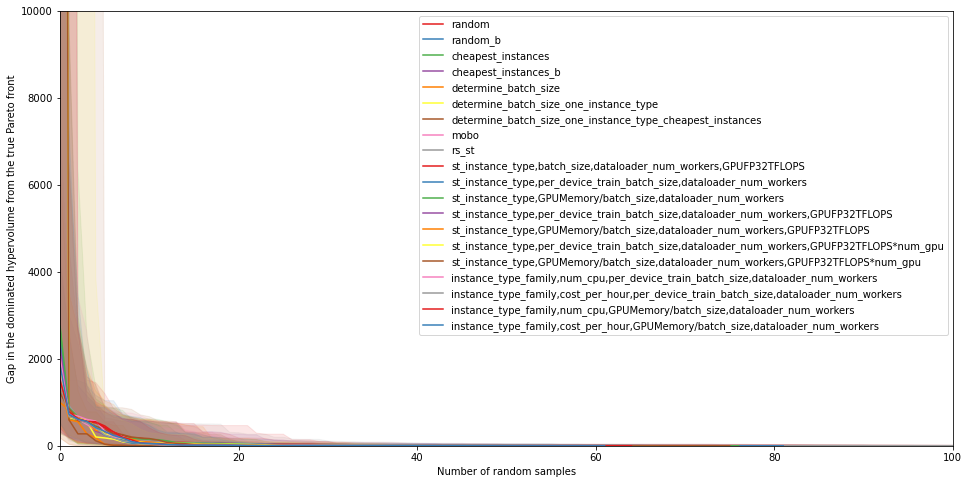

In [50]:
fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')

for k, v in plotting_settings.items():
    ax.plot(np.median(data[k], axis=0), color=v['color'], label=v['label'])

    quantiles = np.quantile(data[k], quantile_values_parameter, axis=0)
    ax.fill_between(x=np.arange(len(quantiles[0])), y1=quantiles[0], y2=quantiles[1], 
                    alpha=0.1, color=v['color'])

ax.set_xlim(0, 100)
ax.set_ylim(0, 10000)

ax.set_xlabel("Number of random samples")
ax.set_ylabel("Gap in the dominated hypervolume from the true Pareto front")

ax.legend()

## plot: vs cost

In [55]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
#     ax.plot(interp_xs, np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])
    fig.add_trace(go.Scatter(x=interp_xs, y=np.mean(data_interpolated, axis=0),
                    mode='lines',
                    name=v['label']))

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
#     ax.fill_between(x=interp_xs, y1=quantiles[0], y2=quantiles[1], 
#                     alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# plt.axvline(x=costs['determine_batch_size'].min(), color='b')

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
# plt.yscale('log',base=10) 
# ax.set_xlim(0., 80)
# ax.set_ylim(1.72955125537556, 30000)
# ax.set_ylim(0.1, 30000)
fig.update_xaxes(range=(0., 80))
fig.update_yaxes(range=(0.23, 4))

# ax.axvline(x=costs['mobo'].mean(axis=0)[4], label='MOBO should start outperform random only here')


# ax.set_xlabel("Cost in $")
# ax.set_ylabel("Gap in the dominated hypervolume from the true Pareto front")

# ax.legend()
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.5,
    xanchor="left",
    x=0.01
))

fig.update_yaxes(type="log")

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

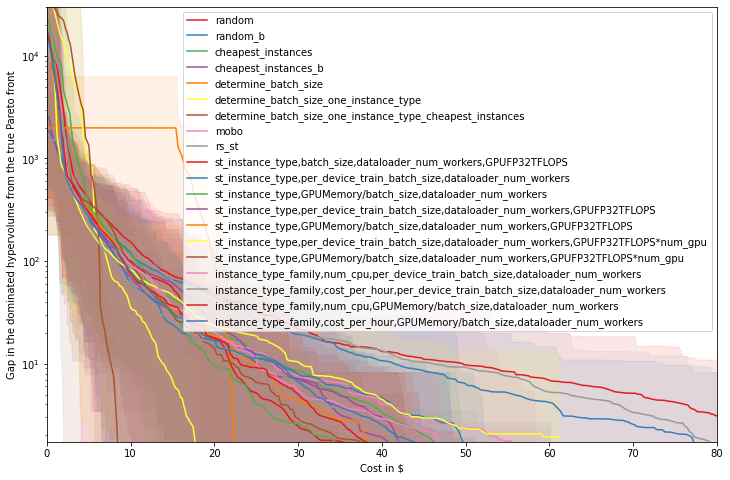

In [52]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
    ax.plot(interp_xs, np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=quantiles[0], y2=quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# plt.axvline(x=costs['determine_batch_size'].min(), color='b')

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
plt.yscale('log',base=10) 
ax.set_xlim(0., 80)
ax.set_ylim(1.72955125537556, 30000)
# ax.set_ylim(0.1, 30000)

# ax.axvline(x=costs['mobo'].mean(axis=0)[4], label='MOBO should start outperform random only here')


ax.set_xlabel("Cost in $")
ax.set_ylabel("Gap in the dominated hypervolume from the true Pareto front")

ax.legend()

KeyError: 'rf_mobo'

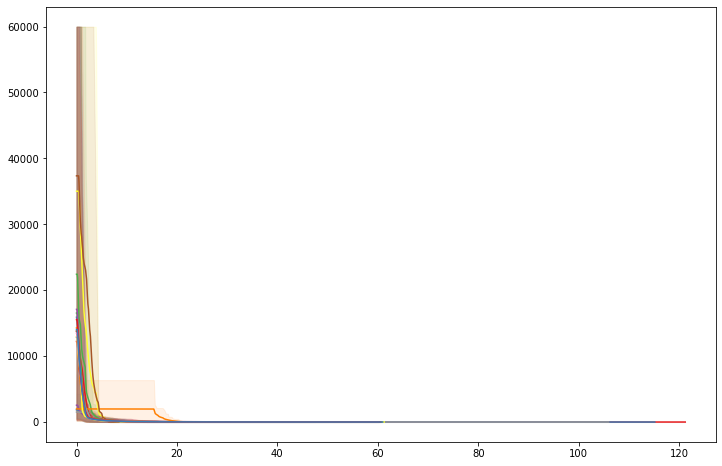

In [53]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    if k == 'mobo':
        continue
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
    ax.plot(interp_xs, np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=quantiles[0], y2=quantiles[1], 
                    alpha=0.1, color=v['color'])

k = 'rf_mobo'
interp_xs_length = 2000
data_interpolated = np.zeros((len(data[k]), interp_xs_length))
interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
for n in range(data[k].shape[0]):
    data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    ax.plot(interp_xs, data_interpolated[n, :], color='k')

# ax.set_xlim(0, 40)

# plt.axvline(x=costs['determine_batch_size'].min(), color='b')

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
plt.yscale('log',base=10) 
ax.set_xlim(0., 80)
ax.set_ylim(1.72955125537556, 30000)
# ax.set_ylim(0.1, 30000)


ax.set_xlabel("Cost in $")
ax.set_ylabel("Gap in the dominated hypervolume from the true Pareto front")

ax.legend()